#### Import Libraries

In [ ]:
# --- System & Utilities ---
import os                    # File and directory operations
import re                    # Regular expressions for string cleaning
import string                # String operations
import ast                   # Safe evaluation of Python expressions
import random                # Random operations (shuffling, sampling)
import time                  # Time tracking for performance
from collections import Counter  # Count frequencies of tokens

# --- Data Handling ---
import pandas as pd          # DataFrames for structured data
import numpy as np           # Numerical operations and arrays

# --- Natural Language Processing (NLP) ---
import nltk
from nltk.tokenize import word_tokenize           # Tokenize sentences/words
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.corpus import stopwords, wordnet        # Common stopwords and WordNet
from nltk.stem import WordNetLemmatizer           # Lemmatization for word normalization
from bert_score import score as bert_score        # Semantic similarity metric

# --- Deep Learning with PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- Visualization & Progress Tracking ---
import matplotlib.pyplot as plt                   # Plotting graphs
from tqdm import tqdm                              # Progress bar for loops

# --- Word Embeddings ---
from gensim.models import KeyedVectors            # Load pretrained word vectors

# --- Memory Management ---
import gc                                          # Garbage collection to manage RAM

# --- Optimization ---
import torch.optim as optim                       # Optimizers (e.g., Adam, SGD)


#### Set up the device

In [ ]:
# --- Device Configuration ---
# Automatically select the best available device: MPS (Apple), CUDA (GPU), or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("✅ Using device:", device)

Using device: mps


#### Special Tokens and Hyperparameters

In [ ]:
# --- Special Tokens & Model Hyperparameters ---
# Define tokens for padding, start/end of sequence, and unknown words
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

# Set model hyperparameters and data preprocessing constants
MAX_INGREDIENT_LEN = 20     # Max number of input tokens
MAX_RECIPE_LEN = 60         # Max number of output tokens
BATCH_SIZE = 64             # Training batch size
EMB_DIM = 64                # Word embedding dimension
HIDDEN_DIM = 256            # RNN hidden state dimension
TEACHER_FORCING_RATIO = 0.8 # Probability of using teacher forcing during training
num_iters = 10000           # Total training iterations
print_every = 50            # Frequency of logging training loss
plot_every = 50             # Frequency of computing validation loss and plotting


#### Data Processing

In [4]:
# Load your CSVs
train_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/train.csv')
dev_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/dev.csv')
test_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/test.csv')

In [ ]:
# --- NLP Preprocessing Utilities ---
lemmatizer = WordNetLemmatizer()                        # Word lemmatizer for reducing words to base form
stop_words = set(stopwords.words('english'))            # English stopwords to remove from text


In [ ]:
# --- Text Cleaning and Formatting Functions ---
def preprocess_text(text):
    """
    Cleans and tokenizes a text string by lowercasing, removing non-alphabetic characters,
    removing stopwords, and applying lemmatization.
    """
    words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return words if words else ["unknown"]

def preprocess_ingredients_column(df):
    """Adds 'input_tokens' column by preprocessing the 'Ingredients' field."""
    df['input_tokens'] = df['Ingredients'].apply(preprocess_text)
    return df

def preprocess_recipes_column(df):
    """Adds 'output_tokens' column by preprocessing the 'Recipe' field."""
    df['output_tokens'] = df['Recipe'].apply(preprocess_text)
    return df

def format_input_prompt(tokens):
    """Formats ingredient tokens as a prompt string for generation."""
    return f"Generate recipe for: {', '.join(tokens)}"

def format_target_text(row):
    """Formats a row into a readable multi-line recipe string."""
    title = row['Title'] if 'Title' in row else 'Generated Recipe'
    ingredients = ', '.join(row['input_tokens'])
    instructions = ', '.join(row['output_tokens'])
    return f"Title: {title}\n\nIngredients:\n{ingredients}\nInstructions:\n{instructions}"

def build_vocab(token_lists):
    """
    Builds vocabulary from token lists and assigns unique index to each token.
    Includes special tokens.
    """
    vocab = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2, UNK_TOKEN: 3}
    counter = Counter(token for tokens in token_lists for token in tokens)
    for token in counter:
        if token not in vocab:
            vocab[token] = len(vocab)
    return vocab

In [ ]:
# --- Apply Preprocessing to Dataset Splits ---
# Tokenize and clean text fields for each split (train/dev/test)
train_df = preprocess_ingredients_column(train_df)
train_df = preprocess_recipes_column(train_df)

dev_df = preprocess_ingredients_column(dev_df)
dev_df = preprocess_recipes_column(dev_df)

test_df = preprocess_ingredients_column(test_df)
test_df = preprocess_recipes_column(test_df)

In [ ]:
# --- Generate Input Prompts for Model ---
# Converts token lists into natural language prompts
train_df['input_prompt'] = train_df['input_tokens'].apply(format_input_prompt)
dev_df['input_prompt'] = dev_df['input_tokens'].apply(format_input_prompt)
test_df['input_prompt'] = test_df['input_tokens'].apply(format_input_prompt)

In [ ]:
# --- Generate Readable Target Texts ---
# Combine title, ingredients, and instructions into formatted strings
train_df['target_text'] = train_df.apply(format_target_text, axis=1)
dev_df['target_text'] = dev_df.apply(format_target_text, axis=1)
test_df['target_text'] = test_df.apply(format_target_text, axis=1)

In [ ]:
# --- Build Vocabularies ---
# Construct token-to-index mappings from training data
input_vocab = build_vocab(train_df['input_tokens'])
output_vocab = build_vocab(train_df['output_tokens'])

# Create reverse index-to-token dictionaries for decoding
input_idx2word = {i: w for w, i in input_vocab.items()}
output_idx2word = {i: w for w, i in output_vocab.items()}

In [11]:
def encode_text(tokens, vocab, max_len, is_target=False):
    """
    Encodes a list of tokens into a fixed-length list of token IDs using a vocabulary.

    Args:
        tokens: List of tokens (strings) to encode.
        vocab: Dictionary mapping tokens to indices.
        max_len: Maximum allowed length of the output sequence.
        is_target: If True, adds <sos> at the start and <eos> at the end.

    Returns:
        A list of token IDs (integers), padded or truncated to max_len.
    """
    encoded = []  # Initialize the list of token IDs

    if is_target:
        # Add <sos> token at the beginning if it's a target sequence
        encoded.append(vocab[SOS_TOKEN])
    
    for tok in tokens:
        # Convert each token to its corresponding index in the vocab
        # Use <unk> token index if token is not found
        encoded.append(vocab.get(tok, vocab[UNK_TOKEN]))

    if is_target:
        # Add <eos> token at the end if it's a target sequence
        encoded.append(vocab[EOS_TOKEN])

    # Ensure the sequence is exactly max_len in length
    if len(encoded) > max_len:
        # Truncate if too long
        encoded = encoded[:max_len]
    else:
        # Pad with <pad> tokens if too short
        encoded += [vocab[PAD_TOKEN]] * (max_len - len(encoded))

    return encoded  # Return the fixed-length list of token indices

In [12]:
class CookingDataset(Dataset):
    def __init__(self, df, input_vocab, output_vocab):
        """
        Args:
            df (DataFrame): The dataset containing tokenized ingredients and recipes.
            input_vocab (dict): Vocabulary mapping for input tokens (ingredients).
            output_vocab (dict): Vocabulary mapping for output tokens (recipes).
        """
        self.df = df
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab

    def __len__(self):
        # Return the number of samples (rows) in the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Get token lists from the DataFrame at the given index
        src_tokens = self.df.iloc[idx]['input_tokens']   # Ingredients
        trg_tokens = self.df.iloc[idx]['output_tokens']  # Recipe steps

        # Encode the tokens using the vocabularies
        src_encoded = encode_text(src_tokens, self.input_vocab, MAX_INGREDIENT_LEN)
        trg_encoded = encode_text(trg_tokens, self.output_vocab, MAX_RECIPE_LEN, is_target=True)

        # Return as PyTorch tensors
        return torch.tensor(src_encoded), torch.tensor(trg_encoded)

In [13]:
def collate_fn(batch):
    """
    Custom collate function for DataLoader to pad sequences in a batch.

    Args:
        batch: A list of (input_tensor, target_tensor) tuples from the dataset.

    Returns:
        src_padded: Padded input tensor of shape (batch_size, max_input_len).
        trg_padded: Padded target tensor of shape (batch_size, max_target_len).
    """
    # Unpack the batch into two lists: inputs and targets
    src_batch, trg_batch = zip(*batch)

    # Pad input sequences to the length of the longest in the batch
    # batch_first=True -> shape will be (batch_size, seq_len)
    src_padded = pad_sequence(
        src_batch, batch_first=True, padding_value=input_vocab[PAD_TOKEN]
    )

    # Pad target sequences similarly
    trg_padded = pad_sequence(
        trg_batch, batch_first=True, padding_value=output_vocab[PAD_TOKEN]
    )

    # Return padded input and target batches
    return src_padded, trg_padded

In [14]:
train_dataset = CookingDataset(train_df, input_vocab, output_vocab)
dev_dataset = CookingDataset(dev_df, input_vocab, output_vocab)
test_dataset = CookingDataset(test_df, input_vocab, output_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

#### Epoch Time Calculation

In [15]:
# Helper function to format time nicely
def epoch_time(start_time, end_time):
    """
    Calculates elapsed time between two time points and formats it into minutes and seconds.

    Args:
        start_time: Float timestamp at the start (e.g., from time.time()).
        end_time: Float timestamp at the end.

    Returns:
        A tuple (minutes, seconds) representing the duration.
    """
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time - (minutes * 60))
    return minutes, seconds

#### Evaluating Matrix

In [16]:
#This line creates a smoothing function for the BLEU score calculation using NLTK’s SmoothingFunction.
smoothie = SmoothingFunction().method4

In [17]:
def evaluate_model(model, data_loader, input_vocab, output_vocab, device, model_name="Seq2Seq-RNN"):
    """
    Evaluates a trained Seq2Seq model using BLEU, METEOR, and BERTScore.

    Args:
        model: The trained sequence-to-sequence model.
        data_loader: A DataLoader for the validation or test set.
        input_vocab: Vocabulary mapping for input tokens (not used in this function).
        output_vocab: Vocabulary mapping for output tokens (used for decoding).
        device: PyTorch device (e.g., 'cuda' or 'cpu').
        model_name: A string label for the model (used in the results dictionary).

    Returns:
        A dictionary containing average BLEU, METEOR, and BERTScore values for the dataset.
    """
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()

    # Initialize lists to store evaluation metrics and text outputs
    bleu_scores = []
    meteor_scores = []
    predictions = []
    references = []

    # Create a reverse mapping from index to word for decoding output tokens
    output_idx2word = {i: w for w, i in output_vocab.items()}

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Loop through batches from the validation/test DataLoader
        for src_batch, trg_batch in tqdm(data_loader, desc="Evaluating"):
            # Move batches to the correct device (CPU or GPU)
            src_batch = src_batch.to(device)
            trg_batch = trg_batch.to(device)

            # Get model predictions without teacher forcing
            output = model(src_batch, trg_batch, teacher_forcing_ratio=0.0)
            
            # Get the most likely token index at each time step
            # Shape: (batch_size, seq_len)
            output_ids = output.argmax(2)

            # Loop through each prediction-reference pair in the batch
            for pred_seq, true_seq in zip(output_ids, trg_batch):
                # Convert predicted token IDs to words, removing special tokens
                pred_tokens = [
                    output_idx2word.get(idx.item(), UNK_TOKEN)
                    for idx in pred_seq
                    if idx.item() not in [output_vocab[PAD_TOKEN], output_vocab[SOS_TOKEN], output_vocab[EOS_TOKEN]]
                ]

                true_tokens = [
                    output_idx2word.get(idx.item(), UNK_TOKEN)
                    for idx in true_seq
                    if idx.item() not in [output_vocab[PAD_TOKEN], output_vocab[SOS_TOKEN], output_vocab[EOS_TOKEN]]
                ]

                # Store string versions for corpus-level evaluation later
                predictions.append(" ".join(pred_tokens))
                references.append(" ".join(true_tokens))

                # Compute individual BLEU and METEOR scores for this sample
                bleu = sentence_bleu([true_tokens], pred_tokens, smoothing_function=smoothie)
                meteor = meteor_score([true_tokens], pred_tokens)

                bleu_scores.append(bleu)
                meteor_scores.append(meteor)

    # Compute BERTScore once for the entire corpus
    try:
        P, R, F1 = bert_score(predictions, references, lang="en", verbose=False)
        bert_f1 = F1.mean().item()
    except Exception as e:
        print(f"⚠️ BERTScore skipped due to error: {e}")
        bert_f1 = None

    # Compute average scores across all samples
    results = {
        "Model": model_name,
        "BLEU": sum(bleu_scores) / len(bleu_scores),
        "METEOR": sum(meteor_scores) / len(meteor_scores),
        "BERTScore": bert_f1 if bert_f1 is not None else "Unavailable"
    }

    return results

#### Evaluation loss

In [18]:
def evaluate_loss(model, val_loader, criterion, output_vocab, device):
    """
    Computes the average loss of a trained model on a validation dataset.

    Args:
        model: Trained Seq2Seq model.
        val_loader: DataLoader for the validation set.
        criterion: Loss function (e.g., nn.CrossEntropyLoss).
        output_vocab: Target vocabulary dictionary (not used directly here).
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        Average validation loss across all batches.
    """
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for src_batch, trg_batch in val_loader:
            src_batch = src_batch.to(device)
            trg_batch = trg_batch.to(device)

            output = model(src_batch, trg_batch, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = trg_batch[:, 1:].reshape(-1)

            loss = criterion(output, target)
            val_loss += loss.item()

    return val_loss / len(val_loader)

#### Training Loop for Model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, output_vocab, device,
                num_iters, print_every, plot_every, teacher_forcing_ratio=0.5, 
                log_filename="training_log.csv", plot_title="Training and Validation Loss"):
    """
    Trains a Seq2Seq model using random batches from the training data.
    Also tracks validation loss and logs progress over time.
    """
    
    import time
    from tqdm import tqdm

    model.train()  # Set model to training mode
    train_losses = []
    val_losses = []
    print_loss_total = 0  # Running total for printing
    plot_loss_total = 0   # Running total for plotting
    first_val_loss = None
    start_time = time.time()

    # Cache all training batches to randomly sample from them
    train_batches = list(train_loader)

    for iteration in range(1, num_iters + 1):
        # === Randomly sample a batch from training set ===
        input_batch, target_batch = random.choice(train_batches)
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        model.train()
        optimizer.zero_grad()  # Reset gradients

        # === Forward pass ===
        output = model(input_batch, target_batch, teacher_forcing_ratio=teacher_forcing_ratio)

        # === Reshape output and target for loss computation ===
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)      # Skip <sos>
        target = target_batch[:, 1:].reshape(-1)

        # === Compute loss and backpropagation ===
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        print_loss_total += loss_value
        plot_loss_total += loss_value

        # === Print training progress every 'print_every' iterations ===
        if iteration % print_every == 0:
            avg_loss = print_loss_total / print_every
            print_loss_total = 0
            elapsed = time.time() - start_time
            print(f"[Iter {iteration:05d}] ⏱ Time: {elapsed:.1f}s | Avg Train Loss: {avg_loss:.4f}")

        # === Validate and track performance every 'plot_every' iterations ===
        if iteration % plot_every == 0:
            val_loss_total = 0
            model.eval()  # Set model to evaluation mode (e.g., disable dropout)
            with torch.no_grad():  # Disable gradient tracking for validation
                for val_input, val_target in val_loader:
                    val_input = val_input.to(device)
                    val_target = val_target.to(device)

                    # In validation, use greedy decoding (no teacher forcing)
                    val_output = model(val_input, val_target, teacher_forcing_ratio=0.0)
                    val_output = val_output[:, 1:].reshape(-1, output_dim)
                    val_target = val_target[:, 1:].reshape(-1)
                    val_loss = criterion(val_output, val_target)
                    val_loss_total += val_loss.item()

            # Compute and store average validation loss
            avg_val_loss = val_loss_total / len(val_loader)
            train_losses.append(plot_loss_total / plot_every)
            val_losses.append(avg_val_loss)
            print(f"📉 Iter {iteration}: Val Loss = {avg_val_loss:.4f}")
            plot_loss_total = 0

    # === Save training and validation loss log to CSV ===
    log_data = {
        "Iteration": list(range(plot_every, plot_every * len(train_losses) + 1, plot_every)),
        "Training Loss": train_losses,
        "Validation Loss": val_losses
    }
    log_df = pd.DataFrame(log_data)
    log_df.to_csv(log_filename, index=False)
    print(f"📁 Training log saved to {log_filename}")

    # === Plot training vs. validation loss ===
    plt.figure(figsize=(8, 6))
    plt.plot(log_data["Iteration"], train_losses, label='Training Loss')
    plt.plot(log_data["Iteration"], val_losses, label='Validation Loss')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Generating the Test Result

In [20]:
def generate_recipe(model, src_tensor, trg_vocab, device, max_len=MAX_RECIPE_LEN, use_attention=False):
    """
    Generates a recipe from a single input using either attention-based or vanilla seq2seq.

    Args:
        model: full seq2seq model or tuple (encoder, decoder)
        src_tensor: tensor of shape (src_len,)
        trg_vocab: target vocabulary (word to index)
        device: torch device (cpu/cuda)
        max_len: max length of the generated recipe
        use_attention: set to True if using (encoder, decoder) attention-style models

    Returns:
        String of generated recipe text.
    """
    model.eval()
    trg_vocab_inv = {i: w for w, i in trg_vocab.items()}

    with torch.no_grad():
        # Add batch dimension: (1, src_len)
        src_tensor = src_tensor.unsqueeze(0).to(device)

        if use_attention:
            # Expecting (encoder, decoder) as a tuple
            encoder, decoder = model
            encoder_outputs, hidden = encoder(src_tensor)

            input_token = torch.tensor([trg_vocab[SOS_TOKEN]], device=device)
            result = []

            for _ in range(max_len):
                output, hidden, _ = decoder(input_token, hidden, encoder_outputs)
                top1 = output.argmax(1).item()

                if top1 == trg_vocab[EOS_TOKEN]:
                    break
                result.append(trg_vocab_inv.get(top1, UNK_TOKEN))
                input_token = torch.tensor([top1], device=device)

        else:
            # Expecting model to be Seq2Seq class with internal encoder+decoder
            dummy_trg = torch.zeros((1, max_len), dtype=torch.long, device=device)
            output = model(src_tensor, dummy_trg, teacher_forcing_ratio=0.0)
            pred_ids = output.argmax(2).squeeze(0).tolist()

            result = []
            for idx in pred_ids:
                token = trg_vocab_inv.get(idx, UNK_TOKEN)
                if token == EOS_TOKEN:
                    break
                if token not in [PAD_TOKEN, SOS_TOKEN]:
                    result.append(token)

    return " ".join(result)

## The 2 Baselines

### Baseline 1 Sequence-to-Sequence model without attention

#### Model

In [21]:
class EncoderRNN(nn.Module):
    """
        RNN-based encoder for a sequence-to-sequence model.

        This module takes an input sequence of token indices, embeds them, and passes the
        embeddings through a RNN to produce hidden state(s) used by the decoder.

        Args:
            input_vocab_size: Size of the input vocabulary.
            emb_dim: Dimensionality of the token embeddings.
            hidden_dim: Dimensionality of the RNN hidden state.

        Methods:
            forward(src): Encodes an input tensor and returns RNN outputs and final hidden state.
            initHidden(): Initializes a zero hidden state tensor.
    """
    def __init__(self, input_vocab_size, emb_dim, hidden_dim):
        super(EncoderRNN, self).__init__()

        # Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(input_vocab_size, emb_dim)

        # RNN layer to process the sequence of embeddings
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)

        # Dropout layer for regularization (helps prevent overfitting)
        self.dropout = nn.Dropout(0.5)

        # Store the hidden state dimension
        self.hidden_size = hidden_dim

    def forward(self, src):
        # src: input sequence tensor of shape (batch_size, seq_len)

        embedded = self.embedding(src)          # Convert tokens to embeddings: (batch_size, seq_len, emb_dim)
        output, hidden = self.rnn(embedded)     # Pass through RNN: output (batch, seq_len, hidden_dim), hidden (1, batch, hidden_dim)
        output = self.dropout(output)           # Apply dropout to the RNN output

        return output, hidden                   # Return both the full sequence output and final hidden state

    def initHidden(self):
        # Create initial hidden state filled with zeros (for single batch/time)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
class DecoderRNN(nn.Module):
    """
    RNN-based decoder for a sequence-to-sequence model.

    This module receives the previous token (or start token), encodes it,
    and generates the next token in the sequence, one step at a time.

    Args:
        output_vocab_size: Size of the output vocabulary.
        emb_dim: Dimensionality of the token embeddings.
        hidden_dim: Dimensionality of the RNN hidden state.

    Methods:
        forward(input_token, hidden): Generates the next token output and updated hidden state.
        initHidden(batch_size, device): Returns an initial hidden state of zeros.
    """
    def __init__(self, output_vocab_size, emb_dim, hidden_dim):
        super(DecoderRNN, self).__init__()

        # Embedding layer to convert token indices to embeddings
        self.embedding = nn.Embedding(output_vocab_size, emb_dim)

        # RNN layer to process embedded tokens one step at a time
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer to project RNN output to vocabulary space
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)

        # Store hidden dimension size
        self.hidden_size = hidden_dim  # ✅ fixed typo

    def forward(self, input_token, hidden):
        # input_token: (batch,) — one token per sequence in the batch

        # Embed the input token and add a time dimension: (batch, 1, emb_dim)
        embedded = self.embedding(input_token).unsqueeze(1)

        # Pass through RNN using the previous hidden state
        # output: (batch, 1, hidden_dim), hidden: (1, batch, hidden_dim)
        output, hidden = self.rnn(embedded, hidden)

        # Apply dropout to RNN output
        output = self.dropout(output)

        # Remove the time dimension and pass through the output layer to get predictions
        # prediction: (batch, vocab_size)
        prediction = self.fc_out(output.squeeze(1))

        return prediction, hidden  # Return predicted token scores and new hidden state

    def initHidden(self, batch_size, device):
        # Initialize the hidden state with zeros: (1, batch, hidden_dim)
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [23]:
class Seq2Seq(nn.Module):
    """
        Sequence-to-sequence model using RNN-based encoder and decoder.

        This model takes an input sequence, encodes it into a hidden state,
        and then generates the output sequence token by token, optionally using
        teacher forcing during training.

        Args:
            encoder: Encoder module (e.g., EncoderRNN).
            decoder: Decoder module (e.g., DecoderRNN).
            device: PyTorch device ('cuda' or 'cpu').

        Methods:
            forward(src, trg, teacher_forcing_ratio):
                Performs a forward pass through the model.
                Returns predicted token distributions for the target sequence.
    """
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()

        # Store encoder and decoder modules
        self.encoder = encoder
        self.decoder = decoder

        # Store device (CPU or GPU)
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Forward pass for sequence-to-sequence model.

        Args:
            src: input sequence tensor of shape (batch, src_len)
            trg: target sequence tensor of shape (batch, trg_len)
            teacher_forcing_ratio: probability of using teacher forcing at each time step

        Returns:
            outputs: tensor of shape (batch, trg_len, vocab_size)
        """

        batch_size = trg.shape[0]           # Number of sequences in the batch
        trg_len = trg.shape[1]              # Maximum target sequence length
        vocab_size = self.decoder.fc_out.out_features  # Size of target vocabulary

        # Initialize tensor to store decoder outputs for each time step
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        # Pass input through encoder (we discard encoder output and only use final hidden state)
        _, hidden = self.encoder(src)  # hidden: (1, batch, hidden_dim)

        # First input to decoder is the <sos> token from target
        input_token = trg[:, 0]  # Shape: (batch,)

        # Decode each time step in the target sequence (excluding first token)
        for t in range(1, trg_len):
            # Pass current input token and hidden state through decoder
            output, hidden = self.decoder(input_token, hidden)  # output: (batch, vocab_size)

            # Store decoder's output prediction at current time step
            outputs[:, t] = output

            # Decide whether to use teacher forcing for next input
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            # Get the most likely predicted token from the decoder's output
            top1 = output.argmax(1)  # Shape: (batch,)

            # If using teacher forcing, use actual target token as next input
            # Otherwise, use model's own prediction
            input_token = trg[:, t] if teacher_force else top1

        # Return all decoder outputs for the full sequence
        return outputs

#### Training the Model

[Iter 00050] ⏱ Time: 24.1s | Avg Train Loss: 9.3593
📉 Iter 50: Val Loss = 9.3154
[Iter 00100] ⏱ Time: 61.7s | Avg Train Loss: 9.1806
📉 Iter 100: Val Loss = 8.7621
[Iter 00150] ⏱ Time: 99.9s | Avg Train Loss: 7.8644
📉 Iter 150: Val Loss = 6.9749
[Iter 00200] ⏱ Time: 136.3s | Avg Train Loss: 6.7985
📉 Iter 200: Val Loss = 6.3488
[Iter 00250] ⏱ Time: 173.1s | Avg Train Loss: 6.4616
📉 Iter 250: Val Loss = 6.1382
[Iter 00300] ⏱ Time: 220.9s | Avg Train Loss: 6.3240
📉 Iter 300: Val Loss = 6.0609
[Iter 00350] ⏱ Time: 265.8s | Avg Train Loss: 6.2759
📉 Iter 350: Val Loss = 6.0243
[Iter 00400] ⏱ Time: 313.3s | Avg Train Loss: 6.2536
📉 Iter 400: Val Loss = 6.0028
[Iter 00450] ⏱ Time: 358.2s | Avg Train Loss: 6.2210
📉 Iter 450: Val Loss = 5.9897
[Iter 00500] ⏱ Time: 401.7s | Avg Train Loss: 6.2135
📉 Iter 500: Val Loss = 5.9789
[Iter 00550] ⏱ Time: 440.6s | Avg Train Loss: 6.2109
📉 Iter 550: Val Loss = 5.9717
[Iter 00600] ⏱ Time: 475.8s | Avg Train Loss: 6.1784
📉 Iter 600: Val Loss = 5.9656
[Iter 00

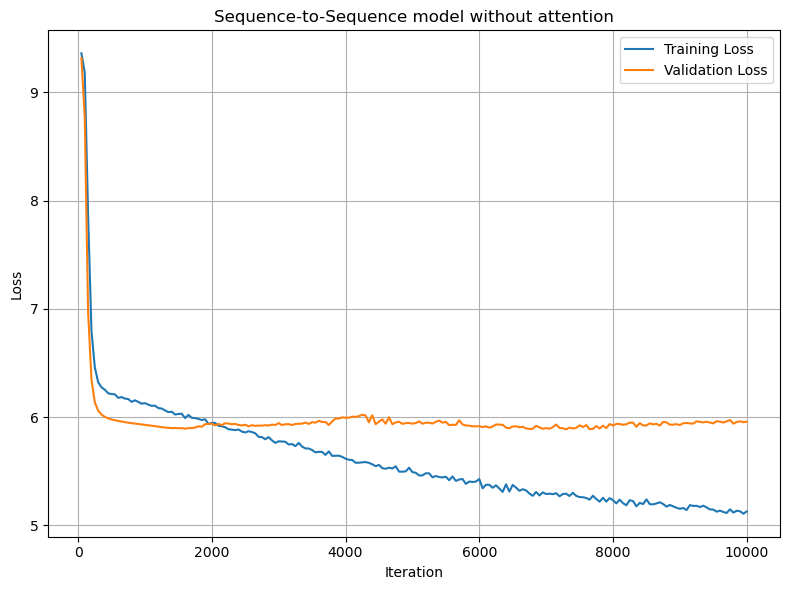

In [ ]:
# === Instantiate encoder, decoder, and Seq2Seq model ===
# EncoderRNN: encodes the input sequence into hidden states
# DecoderRNN: decodes the hidden states into output tokens
encoder = EncoderRNN(input_vocab_size=len(input_vocab), emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM).to(device)
decoder_baseline1 = DecoderRNN(output_vocab_size=len(output_vocab), emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM).to(device)
model_baseline1 = Seq2Seq(encoder, decoder_baseline1, device).to(device)

# === Set up optimizer and loss function ===
# Adam optimizer is used for training; CrossEntropyLoss ignores the PAD token during loss calculation
optimizer = torch.optim.Adam(model_baseline1.parameters(), lr=0.00005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab[PAD_TOKEN])

# === Train the Seq2Seq model ===
# Custom training loop that logs performance and visualizes loss trend
train_model(
    model=model_baseline1,
    train_loader=train_loader,
    val_loader=dev_loader,
    optimizer=optimizer,
    criterion=criterion,
    output_vocab=output_vocab,
    device=device,
    num_iters=num_iters,
    print_every=print_every,
    plot_every=plot_every,
    teacher_forcing_ratio=TEACHER_FORCING_RATIO,
    log_filename="Sequence-to-Sequence model without attention.csv",
    plot_title="Sequence-to-Sequence model without attention"
)

#### Testing the Model

In [25]:
model_baseline1.eval()
baseline1_preds= []

for i in range(len(test_df)):
    ingredients_baseline1 = test_df.iloc[i]['Ingredients']

    # 🔁 Use same preprocessing as training
    tokens_baseline1 = preprocess_text(ingredients_baseline1)
    input_ids_baseline1 = [input_vocab.get(tok, input_vocab[UNK_TOKEN]) for tok in tokens_baseline1]
    input_ids_baseline1 = input_ids_baseline1[:MAX_INGREDIENT_LEN] + [input_vocab[PAD_TOKEN]] * max(0, MAX_INGREDIENT_LEN - len(input_ids_baseline1))

    src_tensor_baseline1 = torch.tensor(input_ids_baseline1, dtype=torch.long, device=device)

    # 🧠 Generate recipe
    generated_recipe_baseline1 = generate_recipe(model_baseline1, src_tensor_baseline1, output_vocab, device, max_len = MAX_RECIPE_LEN, use_attention=False)
    baseline1_preds.append(generated_recipe_baseline1)

# 🗂️ Add predictions to test DataFrame
test_df['Recipe - Baseline 1'] = baseline1_preds

# ✅ Choose columns
columns_to_save_1 = ['Ingredients', 'Recipe - Baseline 1']
if 'Recipe' in test_df.columns:
    columns_to_save_1.insert(1, 'Recipe')

# 💾 Save to timestamped CSV
filename_1 = "baseline1_output.csv"
test_df[columns_to_save_1].to_csv(filename_1, index=False)
print(f"✅ Baseline predictions saved to {filename_1}")

✅ Baseline predictions saved to baseline1_output.csv


#### Evalating the result Matrix

In [27]:
# Evaluate on test_loader (or dev_loader if preferred)
metrics_1 = evaluate_model(model_baseline1, test_loader, input_vocab, output_vocab, device, model_name="Seq2Seq-RNN")

# Step 2: Load existing results if the file exists
results_file = "Assignment_2_evaluation_results.csv"
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    results_df = pd.concat([results_df, pd.DataFrame([metrics_1])], ignore_index=True)
else:
    results_df = pd.DataFrame([metrics_1])

print("Evaluation complete. Results saved to Assignment_2_evaluation_results.csv")
print(results_df)

Evaluating:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 1081/1081 [00:57<00:00, 18.92it/s]
/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation complete. Results saved to Assignment_2_evaluation_results.csv
                  Model      BLEU    METEOR  BERTScore
0           Seq2Seq-RNN  0.007664  0.060587   0.772473
1  Seq2Seq-AttentionRNN  0.005293  0.034299   0.720743
2           Seq2Seq-RNN  0.015220  0.083211   0.808487


### Toy Input texts (gold and predicted recipes)

In [34]:
def predict_recipe_from_input(model, input_text, input_vocab, output_vocab, device,
                              preprocess_fn=preprocess_text,
                              max_input_len=MAX_INGREDIENT_LEN,
                              max_output_len=MAX_RECIPE_LEN,
                              use_attention=False):
    """
    Generate a recipe from an input ingredient list using the provided model.
    
    Args:
        model: Trained Seq2Seq model.
        input_text: Raw ingredient string.
        input_vocab: Dictionary mapping input tokens to indices.
        output_vocab: Dictionary mapping output indices to tokens.
        device: Device to run the model on (CPU or GPU).
        preprocess_fn: Preprocessing function used during training.
        max_input_len: Maximum length of input sequence.
        max_output_len: Maximum length of output recipe.
        use_attention: Whether the model uses attention.

    Returns:
        Generated recipe string.
    """
    model.eval()
    tokens = preprocess_fn(input_text)
    input_ids = [input_vocab.get(tok, input_vocab[UNK_TOKEN]) for tok in tokens]
    input_ids = input_ids[:max_input_len] + [input_vocab[PAD_TOKEN]] * max(0, max_input_len - len(input_ids))

    src_tensor = torch.tensor(input_ids, dtype=torch.long, device=device)

    with torch.no_grad():
        generated_recipe = generate_recipe(model, src_tensor, output_vocab, device,
                                           max_len=max_output_len,
                                           use_attention=use_attention)
    return generated_recipe

In [ ]:
# Example input
user_input = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"

# Change `model_baseline1` to your actual model
output_recipe_baseline1 = predict_recipe_from_input(
    model=model_baseline1, 
    input_text=user_input,
    input_vocab=input_vocab,
    output_vocab=output_vocab,
    device=device,
    use_attention=False  # or True if the model uses attention
)
print("🧾 Generated Recipe baseline1:\n", output_recipe_baseline1)


🧾 Generated Recipe baseline1:
 mix together cream cheese sugar cream cheese sugar add milk add sugar add milk add vanilla stir well add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add
🧾 Generated Recipe attention:
 mix together sugar water add sugar add vanilla add vanilla add mixture pour mixture


In [ ]:
# Example input
user_input = "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"

# Change `model_baseline1` to your actual model
output_recipe_baseline1 = predict_recipe_from_input(
    model=model_baseline1, 
    input_text=user_input,
    input_vocab=input_vocab,
    output_vocab=output_vocab,
    device=device,
    use_attention=False  # or True if the model uses attention
)
print("🧾 Generated Recipe baseline1:\n", output_recipe_baseline1)


🧾 Generated Recipe baseline1:
 mix pudding mix pudding mix well add sugar milk add sugar vanilla add vanilla beat egg white add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg white add vanilla add vanilla add vanilla beat egg
🧾 Generated Recipe attention:
 mix ingredient together add pineapple juice mix well pour pie crust
